### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday, October 15th at 17:00.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


C:\Users\lintl\Anaconda3\envs\rl2019\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\lintl\Anaconda3\envs\rl2019\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [2]:
def binarize(X):
    return (X > 128).astype(np.float)

In [3]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

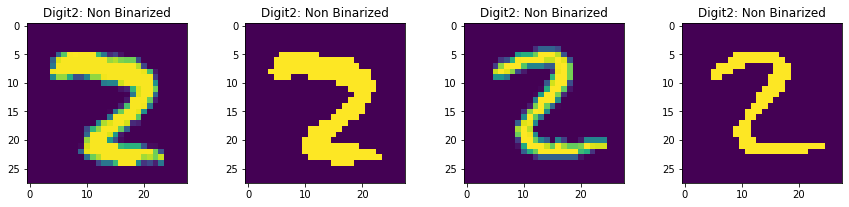

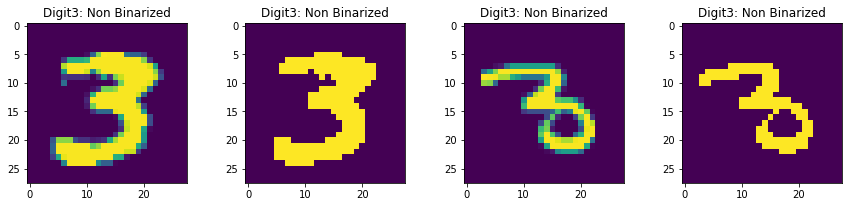

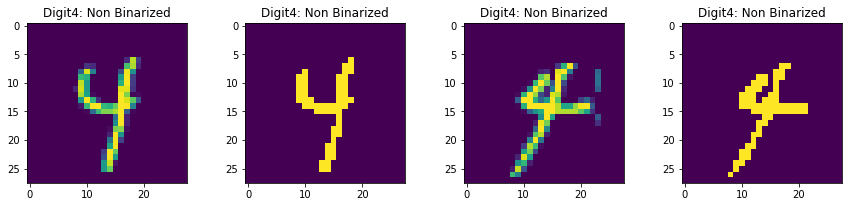

In [4]:
numbers = [2,3,4]

def plot_image(number, images, labels, sample):
    
    index = np.where(labels == number)[0][sample]
   
    title = "Digit" + str(labels[index]) + ":"
    plt.imshow(images[index].reshape(28,28))
    plt.title(title + " Non Binarized")

def plot_bin_non_bin(numbers, train, train_labels, bin_train, sample):
    
    counter = 0
    for i in range(len(numbers)):
        fig = plt.figure(figsize=(15,10))

        plt.subplot(341)
        plot_image(numbers[i], train_data, train_labels, sample[0]) 
        plt.subplot(341 + 1)
        plot_image(numbers[i], bin_train, train_labels, sample[0])
        plt.subplot(341 + 2)
        plot_image(numbers[i], train_data, train_labels, sample[1]) 
        plt.subplot(341 + 3)
        plot_image(numbers[i], bin_train, train_labels, sample[1])
        plt.show()

plot_bin_non_bin(numbers, train_data, train_labels, bin_train_data, [3,4])

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [5]:
def E_step(X, mu, pi):
    # get dimensions of gamma
    X_expand = np.expand_dims(X, axis=1)
    
    unnorm_gamma = pi * np.prod((mu ** X_expand) * ((1 - mu) ** (1 - X_expand)), axis=2)
    
    denominator = np.expand_dims(np.sum(unnorm_gamma, axis=1), axis=1)
    
    gamma = unnorm_gamma / denominator
    return gamma

In [6]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [7]:
def M_step(X, gamma):
    # we sum over the number of datapoints
    N_k = gamma.sum(axis=0)
        
    # pi is the fraction of N_k over the total sum ofer N_k
    pi = N_k / np.sum(N_k)
    
    # expanding with [None,:] and [:, None]
    tmp_mu = gamma[None,:].T * X[None, :]
    
    # unnormalized mu
    unnorm_mu = tmp_mu.sum(axis=1)
    
    # normalized mu
    mu = unnorm_mu / N_k[:, None]
        
    return mu, pi

In [8]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [9]:
def EM(X, K, max_iter, mu=None, pi=None):
    # dimensions
    N = X.shape[0]
    D = X.shape[1]
    
    # parameter initialization
    if mu is None:
        mu = np.random.uniform(0.25, 0.75, (K,D))
    if pi is None:
        pi = np.ones(K) / K
        
    conv_crit = 1e-4
    
    for i in range(max_iter):
        mu_old = mu
        pi_old = pi
        
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma)
        
        mu_update = np.linalg.norm(mu-mu_old)
        pi_update = np.linalg.norm(pi-pi_old)
        
        print("Iteration: {}, delta_mu: {}, delta_pi: {}".format(i, np.round(mu_update, 5),
                                                                     np.round(pi_update, 5)))
            
        if mu_update < conv_crit and pi_update < conv_crit:
            print("After iteration {}, convergence is reached".format(i))
            break
            
    return gamma, mu, pi           


### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [10]:
def plot_mu(mu):
    
    K = mu.shape[0]
    fig, axes = plt.subplots(1, K, figsize=(15, 10))
    
    for k, ax in enumerate(axes):
        ax.imshow(mu[k].reshape((28,28)))
    plt.show()

numbers = [2,3,4]
max_iter = 100

example_train_labels = train_labels[np.isin(train_labels, numbers)]
example_trainbinary = bin_train_data[np.isin(train_labels, numbers), :]


In [11]:
gamma, mu, pi = EM(example_trainbinary, 3, 100)

#show_mu(mu_3)

Iteration: 0, delta_mu: 20.62302, delta_pi: 0.47597
Iteration: 1, delta_mu: 2.69712, delta_pi: 0.16751
Iteration: 2, delta_mu: 1.76431, delta_pi: 0.12087
Iteration: 3, delta_mu: 1.19617, delta_pi: 0.11609
Iteration: 4, delta_mu: 0.6832, delta_pi: 0.06307
Iteration: 5, delta_mu: 0.23769, delta_pi: 0.01967
Iteration: 6, delta_mu: 0.06954, delta_pi: 0.00507
Iteration: 7, delta_mu: 0.02194, delta_pi: 0.00145
Iteration: 8, delta_mu: 0.00868, delta_pi: 0.00052
Iteration: 9, delta_mu: 0.00348, delta_pi: 0.00019
Iteration: 10, delta_mu: 0.00165, delta_pi: 6e-05
Iteration: 11, delta_mu: 0.00181, delta_pi: 8e-05
Iteration: 12, delta_mu: 0.00072, delta_pi: 5e-05
Iteration: 13, delta_mu: 0.00044, delta_pi: 3e-05
Iteration: 14, delta_mu: 0.00095, delta_pi: 4e-05
Iteration: 15, delta_mu: 0.0011, delta_pi: 5e-05
Iteration: 16, delta_mu: 0.00022, delta_pi: 2e-05
Iteration: 17, delta_mu: 9e-05, delta_pi: 1e-05
After iteration 17, convergence is reached


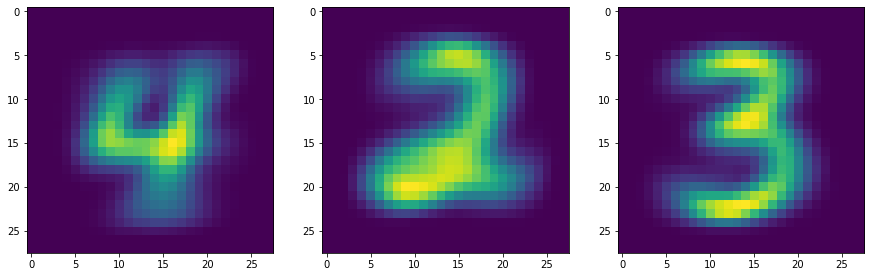

Mixing coefficients: [0.347081   0.31965691 0.33326209]


In [12]:
plot_mu(mu)
print("Mixing coefficients: {}".format(pi))

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

Considering the visualizations, it is obvious that the elements in the latent space illustrate the numbers of the classes, namely 2,3,4. So, in the above shown images, the activated regions illustrate probabilities represent if a pixel is active and therefore, the shape of the digits is detectable. 

The mixing coefficients are uniformly distributed, which is in line with the assumption, that each number appears equally often. 


### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Iteration: 0, delta_mu: 17.0123, delta_pi: 0.33843
Iteration: 1, delta_mu: 1.51294, delta_pi: 0.12849
Iteration: 2, delta_mu: 0.55297, delta_pi: 0.06481
Iteration: 3, delta_mu: 0.52761, delta_pi: 0.05617
Iteration: 4, delta_mu: 0.529, delta_pi: 0.05015
Iteration: 5, delta_mu: 0.45342, delta_pi: 0.0359
Iteration: 6, delta_mu: 0.3342, delta_pi: 0.01891
Iteration: 7, delta_mu: 0.20109, delta_pi: 0.00267
Iteration: 8, delta_mu: 0.12291, delta_pi: 0.00508
Iteration: 9, delta_mu: 0.08375, delta_pi: 0.00647
Iteration: 10, delta_mu: 0.06812, delta_pi: 0.00683
Iteration: 11, delta_mu: 0.06632, delta_pi: 0.00736
Iteration: 12, delta_mu: 0.06722, delta_pi: 0.00756
Iteration: 13, delta_mu: 0.06367, delta_pi: 0.00733
Iteration: 14, delta_mu: 0.05885, delta_pi: 0.00697
Iteration: 15, delta_mu: 0.05501, delta_pi: 0.00639
Iteration: 16, delta_mu: 0.05351, delta_pi: 0.00606
Iteration: 17, delta_mu: 0.05687, delta_pi: 0.00631
Iteration: 18, delta_mu: 0.05574, delta_pi: 0.00619
Iteration: 19, delta_mu: 0

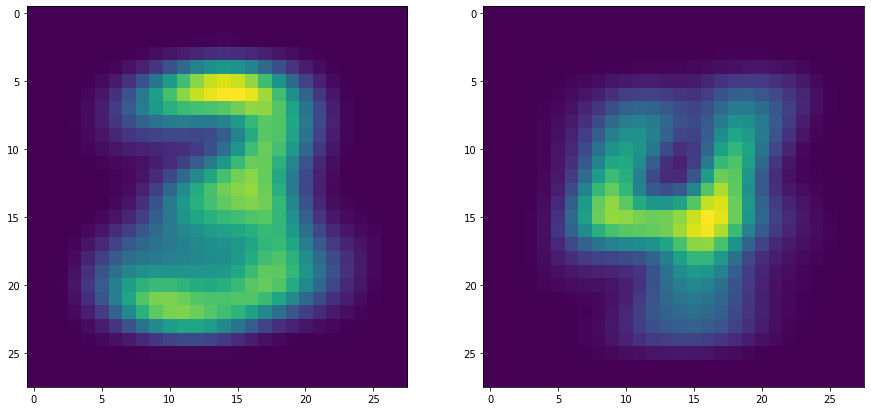

Mixing coefficients for 2 classes: [0.63115088 0.36884912]


In [13]:
gamma_2, mu_2, pi_2 = EM(example_trainbinary, 2, 100)
plot_mu(mu_2)
print("Mixing coefficients for 2 classes: {}".format(pi_2))

Iteration: 0, delta_mu: 26.54926, delta_pi: 0.62313
Iteration: 1, delta_mu: 3.88505, delta_pi: 0.4943
Iteration: 2, delta_mu: 1.82397, delta_pi: 0.08689
Iteration: 3, delta_mu: 1.34471, delta_pi: 0.04266
Iteration: 4, delta_mu: 0.92996, delta_pi: 0.03215
Iteration: 5, delta_mu: 0.60358, delta_pi: 0.02043
Iteration: 6, delta_mu: 0.49192, delta_pi: 0.01428
Iteration: 7, delta_mu: 0.50295, delta_pi: 0.01212
Iteration: 8, delta_mu: 0.5553, delta_pi: 0.01264
Iteration: 9, delta_mu: 0.51952, delta_pi: 0.01177
Iteration: 10, delta_mu: 0.49096, delta_pi: 0.01224
Iteration: 11, delta_mu: 0.39866, delta_pi: 0.01012
Iteration: 12, delta_mu: 0.27349, delta_pi: 0.00712
Iteration: 13, delta_mu: 0.18812, delta_pi: 0.00473
Iteration: 14, delta_mu: 0.10775, delta_pi: 0.00298
Iteration: 15, delta_mu: 0.06151, delta_pi: 0.00186
Iteration: 16, delta_mu: 0.03416, delta_pi: 0.00114
Iteration: 17, delta_mu: 0.02797, delta_pi: 0.00102
Iteration: 18, delta_mu: 0.02722, delta_pi: 0.00106
Iteration: 19, delta_mu

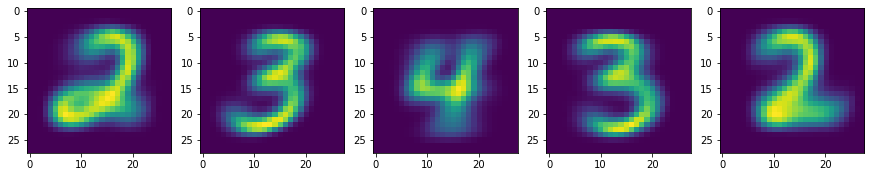

Mixing coefficients for 5 classes: [0.347081   0.31965691 0.33326209]


In [14]:
gamma_5, mu_5, pi_5 = EM(example_trainbinary, 5, 100)
plot_mu(mu_5)
print("Mixing coefficients for 5 classes: {}".format(pi))

The first case, a number smaller than the actual number of classes, the convergence of $\mu_k$s to the actual classes is not guaranteed anymore, as seen in the picture, the first image is not clearly a three, but rather a mixture between three and two. The second image actually looks like it converged to a proper 4. 

For the larger case, we see, that convergence in itself takes much longer. Also, it is notable that the digits 4 and 2 are represented doubly. Therefore, compared to the smaller number of classes each $\mu_k$ seemingly actually converged to a true class, as none of the shown digits seems distorted or as a mixture of classes. It is also notable, that the digits of the same class vary in their look (the two 2s and 4s seem different), which might stemm from the fact that they reflect a different region of the possible shapes of the respective digits. 

The mixture components seem to adapt, as they stay relatively uniform. 

So, both a too small and a too large number of classes lead to acuracy loss. Once, the classes are mixed and once multiple representations appear. 

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

NotImplementedError: 

YOUR ANSWER HERE

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

YOUR ANSWER HERE

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [16]:
def log_bernoulli_loss(x_hat, x):
    
    loss = -torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))
    return loss


In [17]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [18]:
def KL_loss(mu, logvar):
    
    loss = -(1/2) * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss


In [19]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [20]:
def loss_function(x_hat, x, mu, logvar):
    
    loss = log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)
    return loss


In [21]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [22]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [23]:
def encode(self, x):
    
    h1 = F.relu(self.fc1(x))
    mu = self.fc21(h1)
    logvar = self.fc22(h1)

    return mu, logvar


In [24]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [25]:
def reparameterize(self, mu, logvar):
            
        return  mu + torch.exp(1/2 * logvar) * torch.randn_like(mu)


In [26]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [27]:
def decode(self, z):
    
    h1 = self.fc3(z)
    h1 = F.relu(h1)
    h1 = self.fc4(h1)
    x_hat = F.sigmoid(h1)
    return x_hat


In [28]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


C:\Users\lintl\Anaconda3\envs\rl2019\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [29]:
def forward(self, x):
    x = x.view(-1, 784)
    
    mu, logvar = self.encode(x)
    
    z = self.reparameterize(mu, logvar)
    
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [30]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [31]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [32]:
# Hyperparameters
fc1_dims = (784, 400)
fc21_dims = (400, 20)
fc22_dims = (400, 20)
fc3_dims = (20, 400)
fc4_dims = (400, 784)
lr = 1e-4
batch_size = 120
epochs = 10


In [33]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [34]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 550.567566
Train Epoch: 1 [12000/60000 (20%)]	Loss: 268.343658
Train Epoch: 1 [24000/60000 (40%)]	Loss: 235.497818
Train Epoch: 1 [36000/60000 (60%)]	Loss: 212.567719
Train Epoch: 1 [48000/60000 (80%)]	Loss: 207.858917
====> Epoch: 1 Average loss: 254.7273
Train Epoch: 2 [0/60000 (0%)]	Loss: 192.445572
Train Epoch: 2 [12000/60000 (20%)]	Loss: 184.283844
Train Epoch: 2 [24000/60000 (40%)]	Loss: 174.772934
Train Epoch: 2 [36000/60000 (60%)]	Loss: 176.407883
Train Epoch: 2 [48000/60000 (80%)]	Loss: 168.189941
====> Epoch: 2 Average loss: 174.8130
Train Epoch: 3 [0/60000 (0%)]	Loss: 161.005066
Train Epoch: 3 [12000/60000 (20%)]	Loss: 158.476639
Train Epoch: 3 [24000/60000 (40%)]	Loss: 156.709290
Train Epoch: 3 [36000/60000 (60%)]	Loss: 158.456818
Train Epoch: 3 [48000/60000 (80%)]	Loss: 151.390640
====> Epoch: 3 Average loss: 155.7453
Train Epoch: 4 [0/60000 (0%)]	Loss: 151.145935
Train Epoch: 4 [12000/60000 (20%)]	Loss: 137.667313
Train Epoch: 4 [24000/

Run the box below to check if the model you trained above is able to correctly reconstruct images.

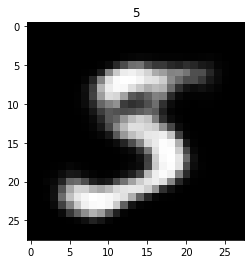

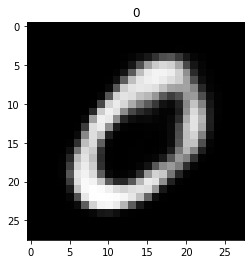

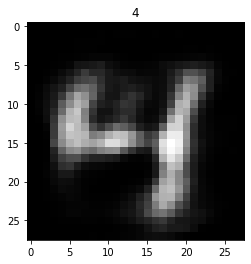

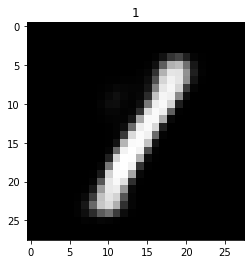

In [35]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [36]:
fc1_dims = (784, 256)
fc21_dims = (256, 2)
fc22_dims = (256, 2)
fc3_dims = (2, 256)
fc4_dims = (256, 784)
lr = 1e-4
batch_size = 128
epochs = 10

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims,
                fc21_dims=fc21_dims,
                fc22_dims=fc22_dims,
                fc3_dims=fc3_dims,
                fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 551.562500
Train Epoch: 1 [12800/60000 (21%)]	Loss: 263.747467
Train Epoch: 1 [25600/60000 (43%)]	Loss: 238.770248
Train Epoch: 1 [38400/60000 (64%)]	Loss: 221.702301
Train Epoch: 1 [51200/60000 (85%)]	Loss: 223.060852
====> Epoch: 1 Average loss: 264.5905
Train Epoch: 2 [0/60000 (0%)]	Loss: 208.024170
Train Epoch: 2 [12800/60000 (21%)]	Loss: 211.439774
Train Epoch: 2 [25600/60000 (43%)]	Loss: 202.066025
Train Epoch: 2 [38400/60000 (64%)]	Loss: 198.744766
Train Epoch: 2 [51200/60000 (85%)]	Loss: 193.100998
====> Epoch: 2 Average loss: 199.6053
Train Epoch: 3 [0/60000 (0%)]	Loss: 190.765076
Train Epoch: 3 [12800/60000 (21%)]	Loss: 192.474442
Train Epoch: 3 [25600/60000 (43%)]	Loss: 187.244492
Train Epoch: 3 [38400/60000 (64%)]	Loss: 187.458191
Train Epoch: 3 [51200/60000 (85%)]	Loss: 190.158081
====> Epoch: 3 Average loss: 190.6890
Train Epoch: 4 [0/60000 (0%)]	Loss: 187.374985
Train Epoch: 4 [12800/60000 (21%)]	Loss: 180.420563
Train Epoch: 4 [25600/

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?
